<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [86]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [87]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [88]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

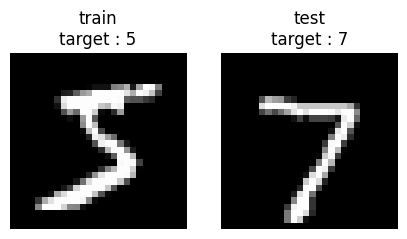

In [89]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [90]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=64, num_flows=10)

train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)


In [91]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1094.8137715657551
Epoch :  2   -----------> Loss :  1001.1126454671224
Epoch :  3   -----------> Loss :  909.2924397786459
Epoch :  4   -----------> Loss :  818.0720876057943
Epoch :  5   -----------> Loss :  728.5220438639323
Epoch :  6   -----------> Loss :  640.5805714925131
Epoch :  7   -----------> Loss :  553.3360697428385
Epoch :  8   -----------> Loss :  468.27960205078125
Epoch :  9   -----------> Loss :  386.77589416503906
Epoch :  10   -----------> Loss :  305.53946685791016
Epoch :  11   -----------> Loss :  228.85589090983072
Epoch :  12   -----------> Loss :  157.55128733317056
Epoch :  13   -----------> Loss :  85.01702340443929
Epoch :  14   -----------> Loss :  28.436295588811237
Epoch :  15   -----------> Loss :  -41.63316615422567
Epoch :  16   -----------> Loss :  -103.80562019348145
Epoch :  17   -----------> Loss :  -163.45368067423502
Epoch :  18   -----------> Loss :  -216.2248738606771
Epoch :  19   -----------> Loss :  -264.5

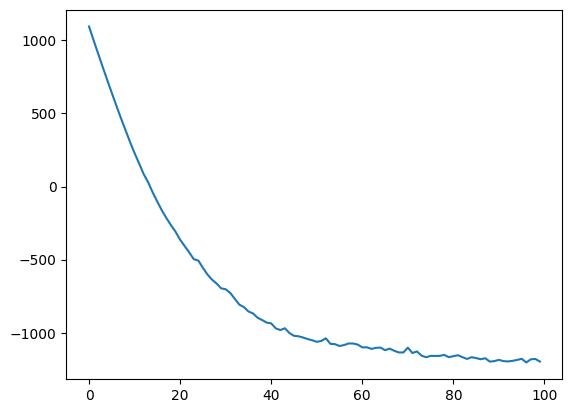

In [92]:
plt.plot(COST)

In [93]:
test = prior.sample((50,))
test

tensor([[-0.9496,  1.2759, -0.5282,  ...,  0.4410, -0.2701, -0.0647],
        [-1.0908, -1.1059, -0.2287,  ..., -1.0070,  0.1026,  0.2972],
        [-0.9196,  0.0320,  0.1191,  ..., -1.1958,  1.3095,  1.3704],
        ...,
        [-1.0640, -0.2452,  1.3034,  ...,  0.2895,  0.0966,  0.5603],
        [ 0.5154, -0.7996,  2.6288,  ...,  0.4008,  1.4295,  1.4929],
        [-0.6779,  0.0662, -0.8429,  ...,  1.6278,  1.3766,  0.1510]])

In [94]:
sonuc = model.f_inv(test)
sonuc

tensor([[-3.1695e-03,  5.7709e-03, -1.6154e-03,  ..., -3.0649e-03,
         -1.4708e-03,  1.8919e-02],
        [-3.6494e-03, -5.1251e-03, -5.0205e-04,  ..., -6.6885e-03,
          3.3958e-04,  1.9369e-02],
        [-3.0819e-03,  1.1864e-04,  1.1849e-03,  ..., -6.6553e-03,
          6.2829e-03,  2.3708e-02],
        ...,
        [-3.5766e-03, -1.1861e-03,  6.4729e-03,  ..., -2.4279e-03,
          4.3966e-05,  2.1529e-02],
        [ 1.7864e-03, -3.7723e-03,  1.3078e-02,  ..., -2.8665e-03,
          6.8753e-03,  2.3326e-02],
        [-2.2346e-03,  2.4015e-04, -3.2320e-03,  ...,  2.9429e-03,
          6.3907e-03,  1.8767e-02]], grad_fn=<CopySlices>)

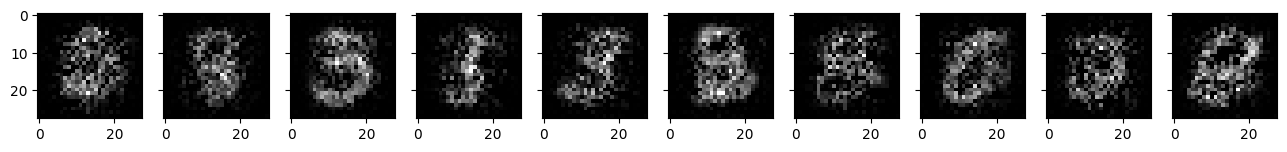

In [95]:
test = prior.sample((10,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0,10):

    axs[i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((28,28)), cmap='gray')
    #axs[i].axis('off')

fig.show()